In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
configOnline = configClasses.OnlineLearningConfig()
configOnline.L1_REG = 0
configOnline.EPOCHS = 20
configOnline.SAVE_PATH = './models/trainable_dict'
configOnline.IS_CONVOLUTIONAL = False
configOnline.MODEL_NAME = ''
print(configOnline)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/trainable_dict
USE_EWC: True
USE_TENSORBOARD: True



In [6]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [7]:
results = []

def copy_weights(net1, net2):
    model_dict = net1.state_dict()
    pretrained_dict = {k: v for k, v in net2.state_dict().items() if 'dict' not in k and 'alpha' not in k}
    model_dict.update(pretrained_dict)
    return model_dict

In [8]:
trainable_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), trainable_dict=True)
nontrainable_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), trainable_dict=False)
trainable_net.load_state_dict(copy_weights(trainable_net, nontrainable_net))

In [9]:
n = deepcopy(nontrainable_net)
config = deepcopy(configOnline)

config.MODEL_NAME = 'non_trainable'

trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

r = trainer.load()
if not r:
    r = trainer.all_tasks()

results.append(('non_trainable', r))

del trainer
del n

In [10]:
n = deepcopy(trainable_net)
config = deepcopy(configOnline)

config.MODEL_NAME = 'trainable'

trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

r = trainer.load()
if not r:
    r = trainer.all_tasks()

results.append(('trainable', r))

del trainer
del n

In [11]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics'])
    print()

RESULTS
non_trainable {'fwt': 0.9405833333333334, 'bwt': -0.009750000000000017, 'remembering': 0.99025, 'pbwt': 0, 'accuracy': 0.43001428571428574}

trainable {'fwt': 0.9458928571428572, 'bwt': -0.005892857142857107, 'remembering': 0.9941071428571429, 'pbwt': 0, 'accuracy': 0.44471428571428573}



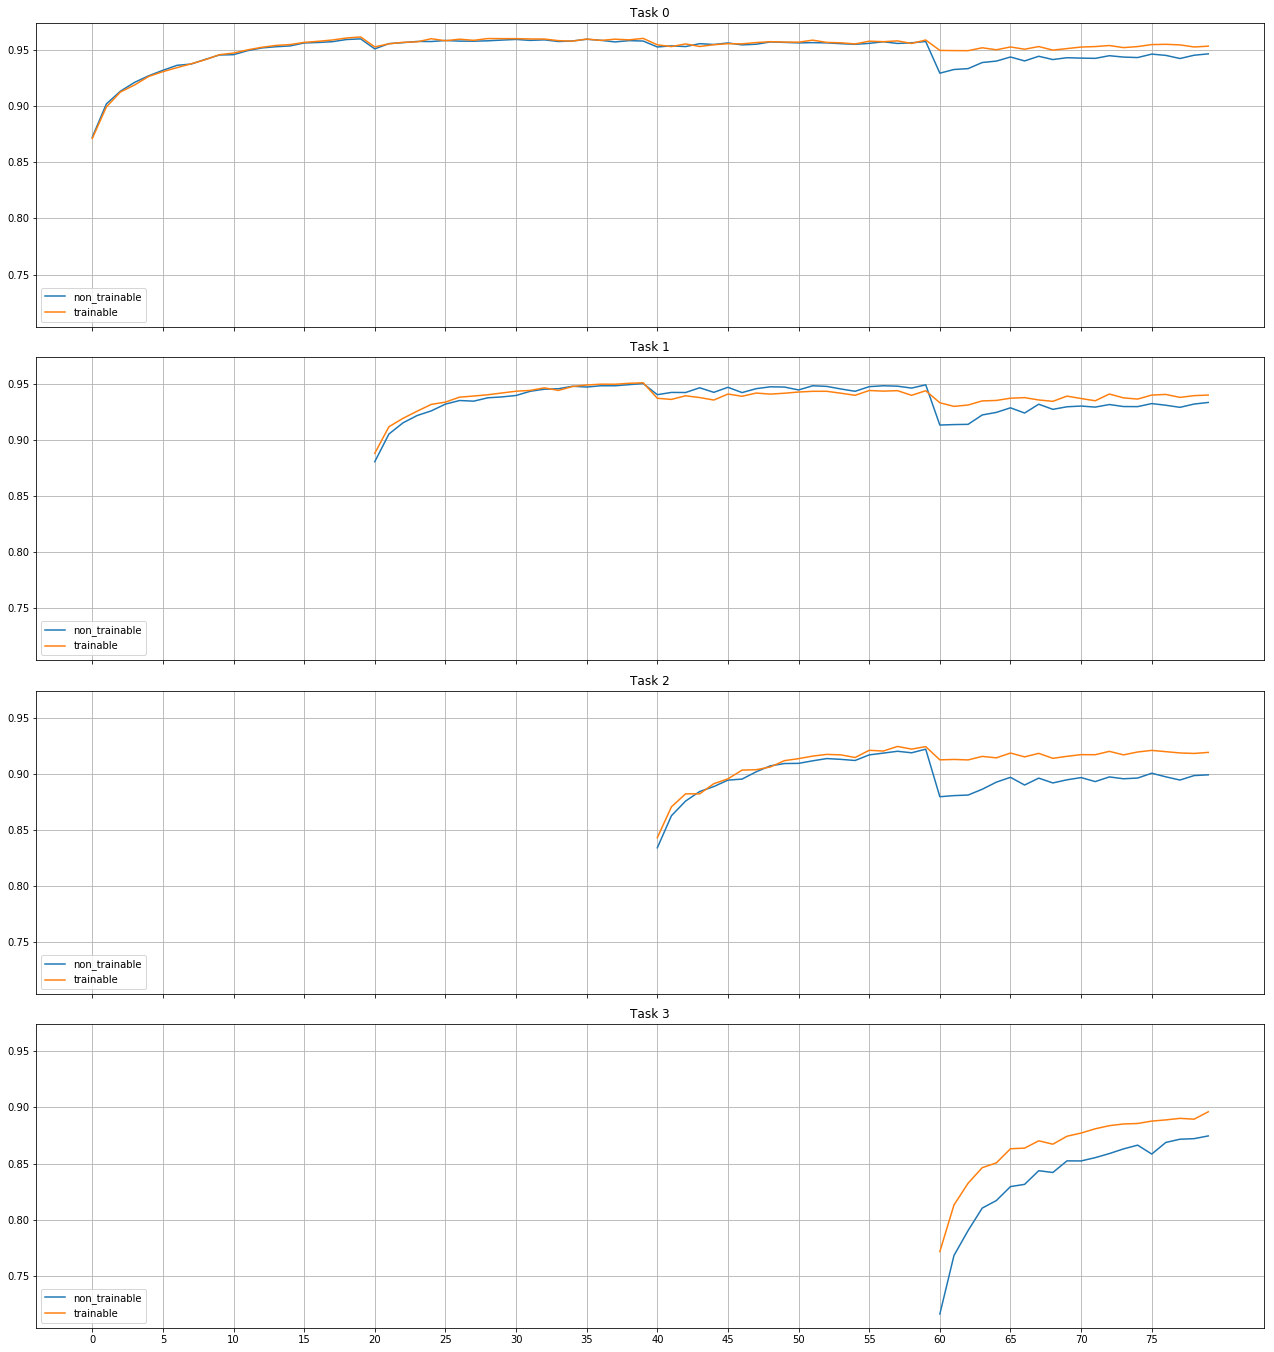

In [12]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=n_task, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        ax[i].plot(x, com['accuracy'], label=name)

        ax[i].set_xticks(range(0, tot_epochs, 5),minor=False)

        ax[i].set_title("Task {}".format(task))
        ax[i].legend(loc="lower left")
        ax[i].grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)


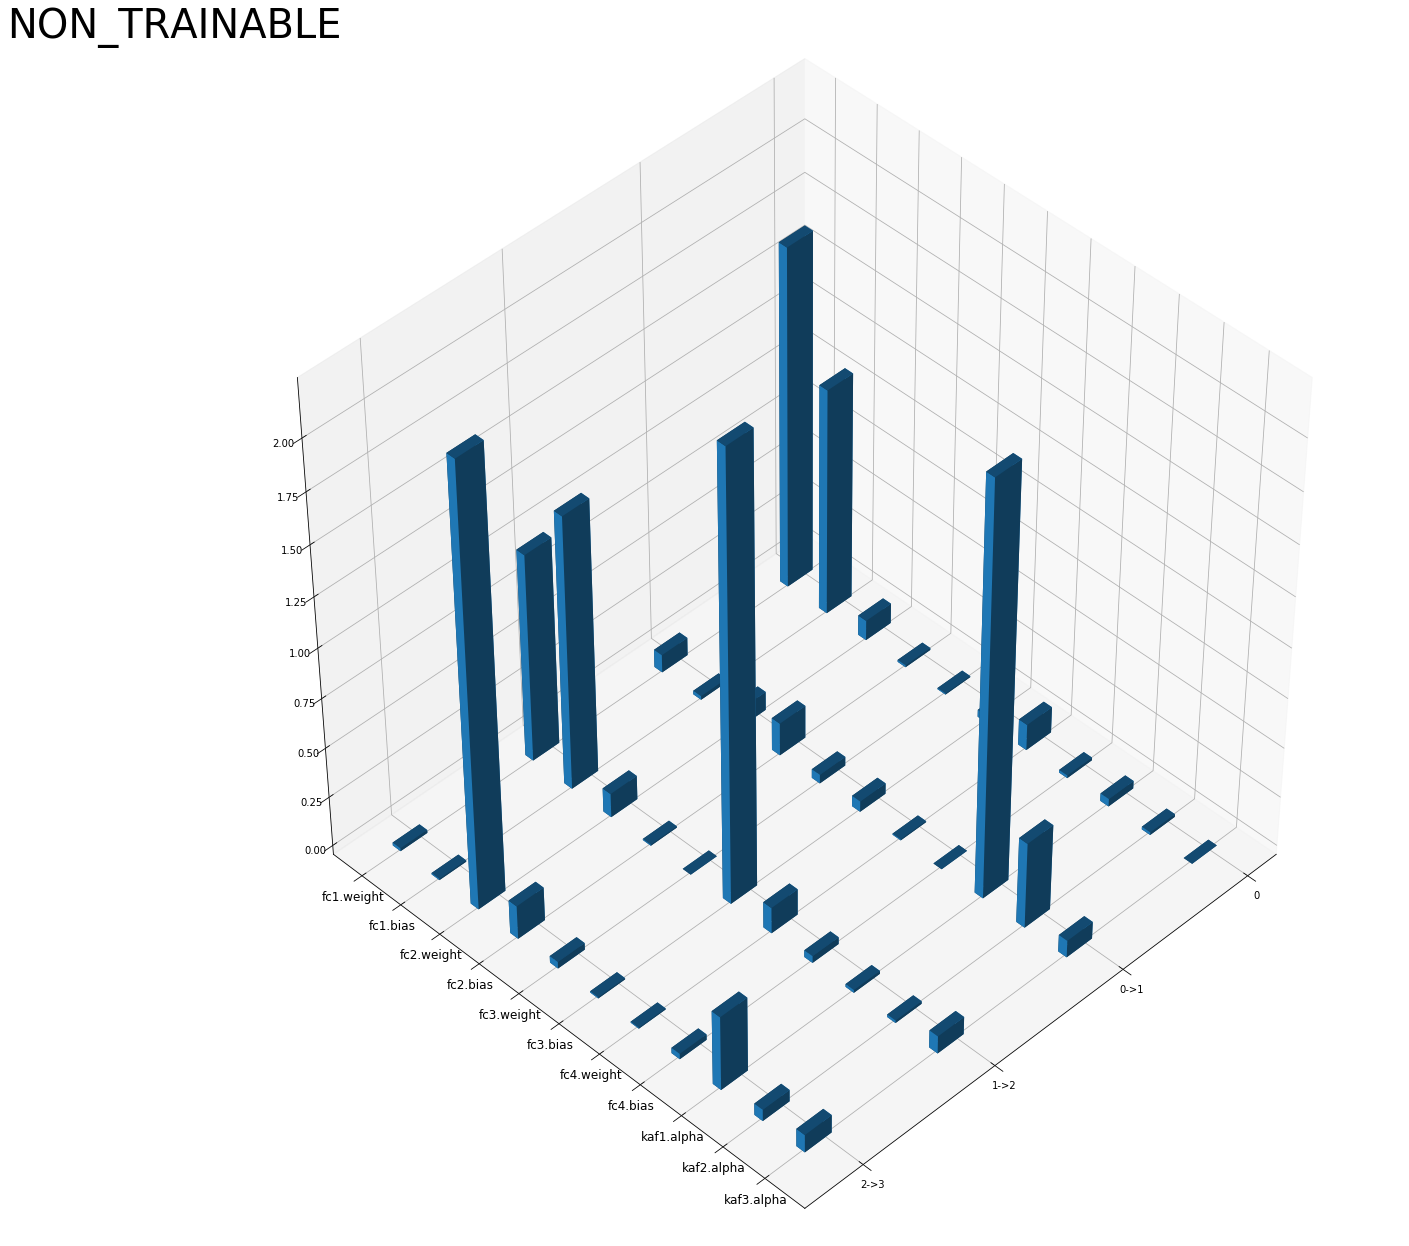

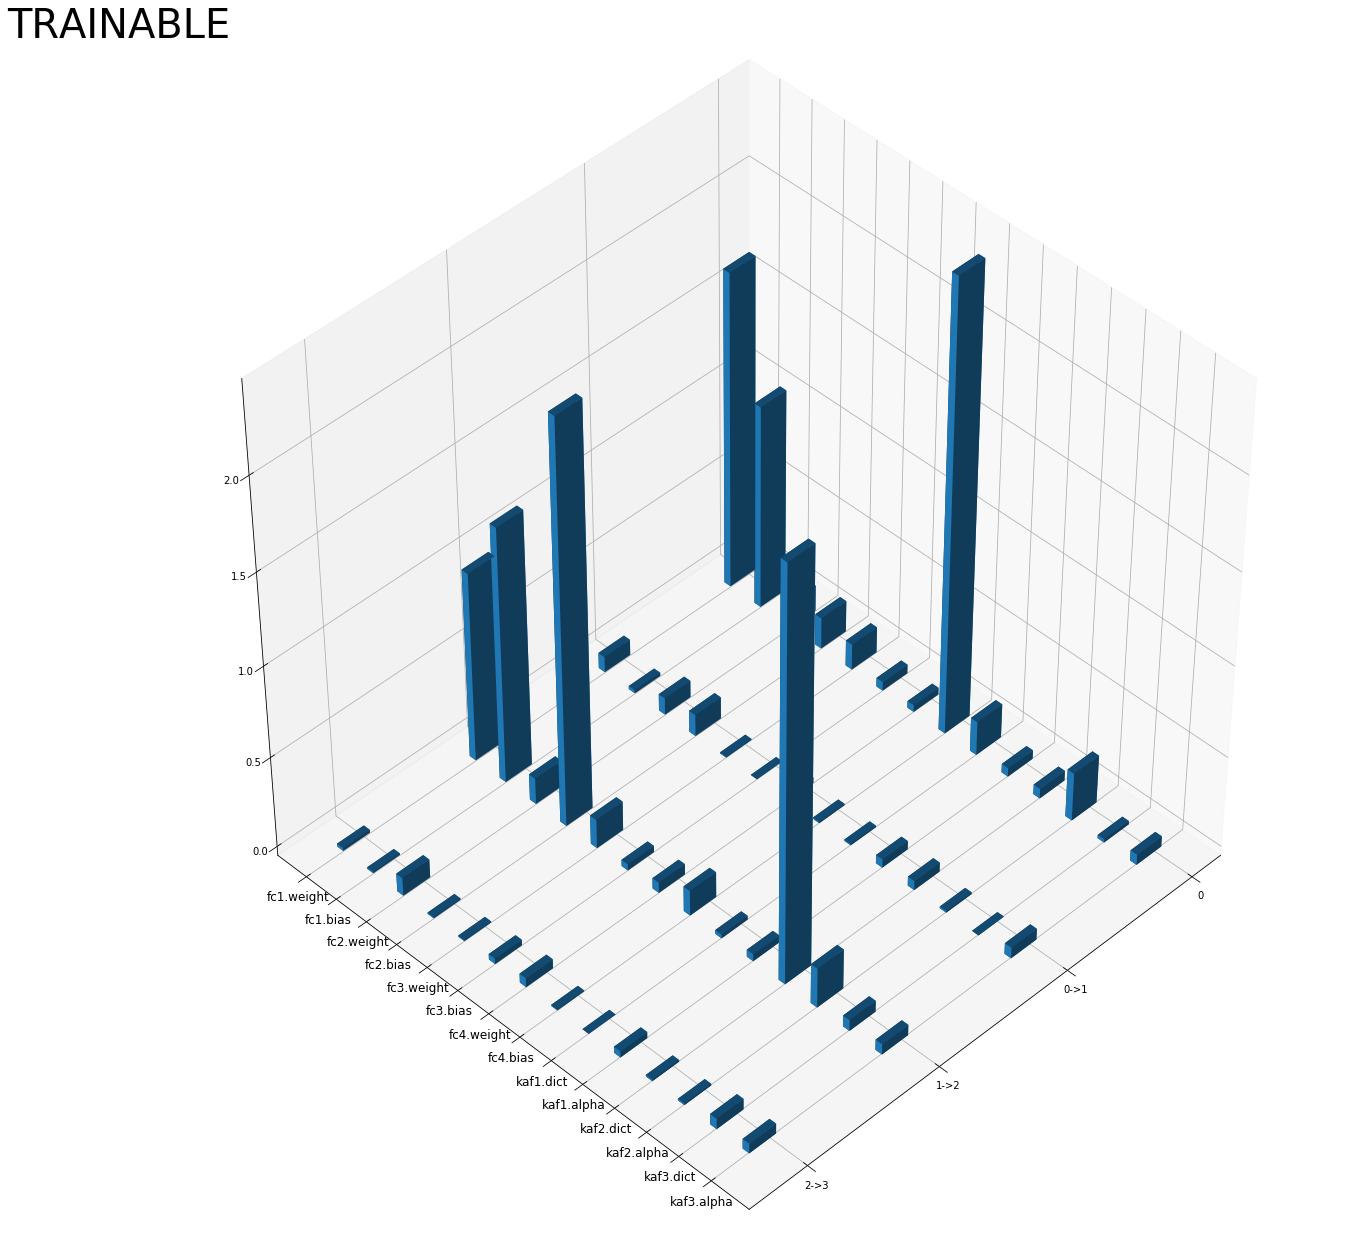

In [13]:
from mpl_toolkits.mplot3d import Axes3D

for name, _ in results:
    
    if name == 'trainable':
        local_net = trainable_net 
    else:
        local_net = nontrainable_net
        
    current_w = {n:p.cpu() for n, p in local_net.named_parameters() if p.requires_grad}

    x = np.arange(4)
    y = np.arange(len(current_w))
    
    xx, yy = np.meshgrid(x, y)
    z = np.zeros(shape=(len(x), len(y)))
    
    fig = plt.figure(figsize=(22, 22))
    ax = fig.add_subplot(111, projection='3d')
    
    x_labels = []
    
    for i in x:

        if i == 0:
            x_labels.append('0')
            
        else:
            x_labels.append('{}->{}'.format(i-1, i))
        
        
        n = deepcopy(local_net)
        config = deepcopy(configOnline)

        config.MODEL_NAME = name

        trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

        r = trainer.load(i)
        
        diff = {n: torch.dist(p.cpu(), current_w[n]) for n, p in trainer.model.named_parameters() if p.requires_grad }
        current_w = {n: p.cpu() for n, p in trainer.model.named_parameters() if p.requires_grad }
        
        for j, (_, d) in enumerate(diff.items()):
            z[i, j] = d
    

    z_n = z.flatten()

    ax.view_init(45, 45)
    
    ax.bar3d(xx.flatten(),
          yy.flatten(),
          np.zeros(len(z_n)),
          0.2, 0.2, z_n )
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    ax.set_yticks(y)
    ax.set_yticklabels(list(diff.keys()), fontdict={'fontsize':12})
    
#     ax.text(3.5, 0, 2, name.upper(), color='black',  fontsize='xx-large', 
#         bbox=dict(facecolor='white', edgecolor='black'))
    
    ax.set_title(name.upper(), fontdict={'fontsize':40}, loc='left', horizontalalignment='center')
    
    plt.show()

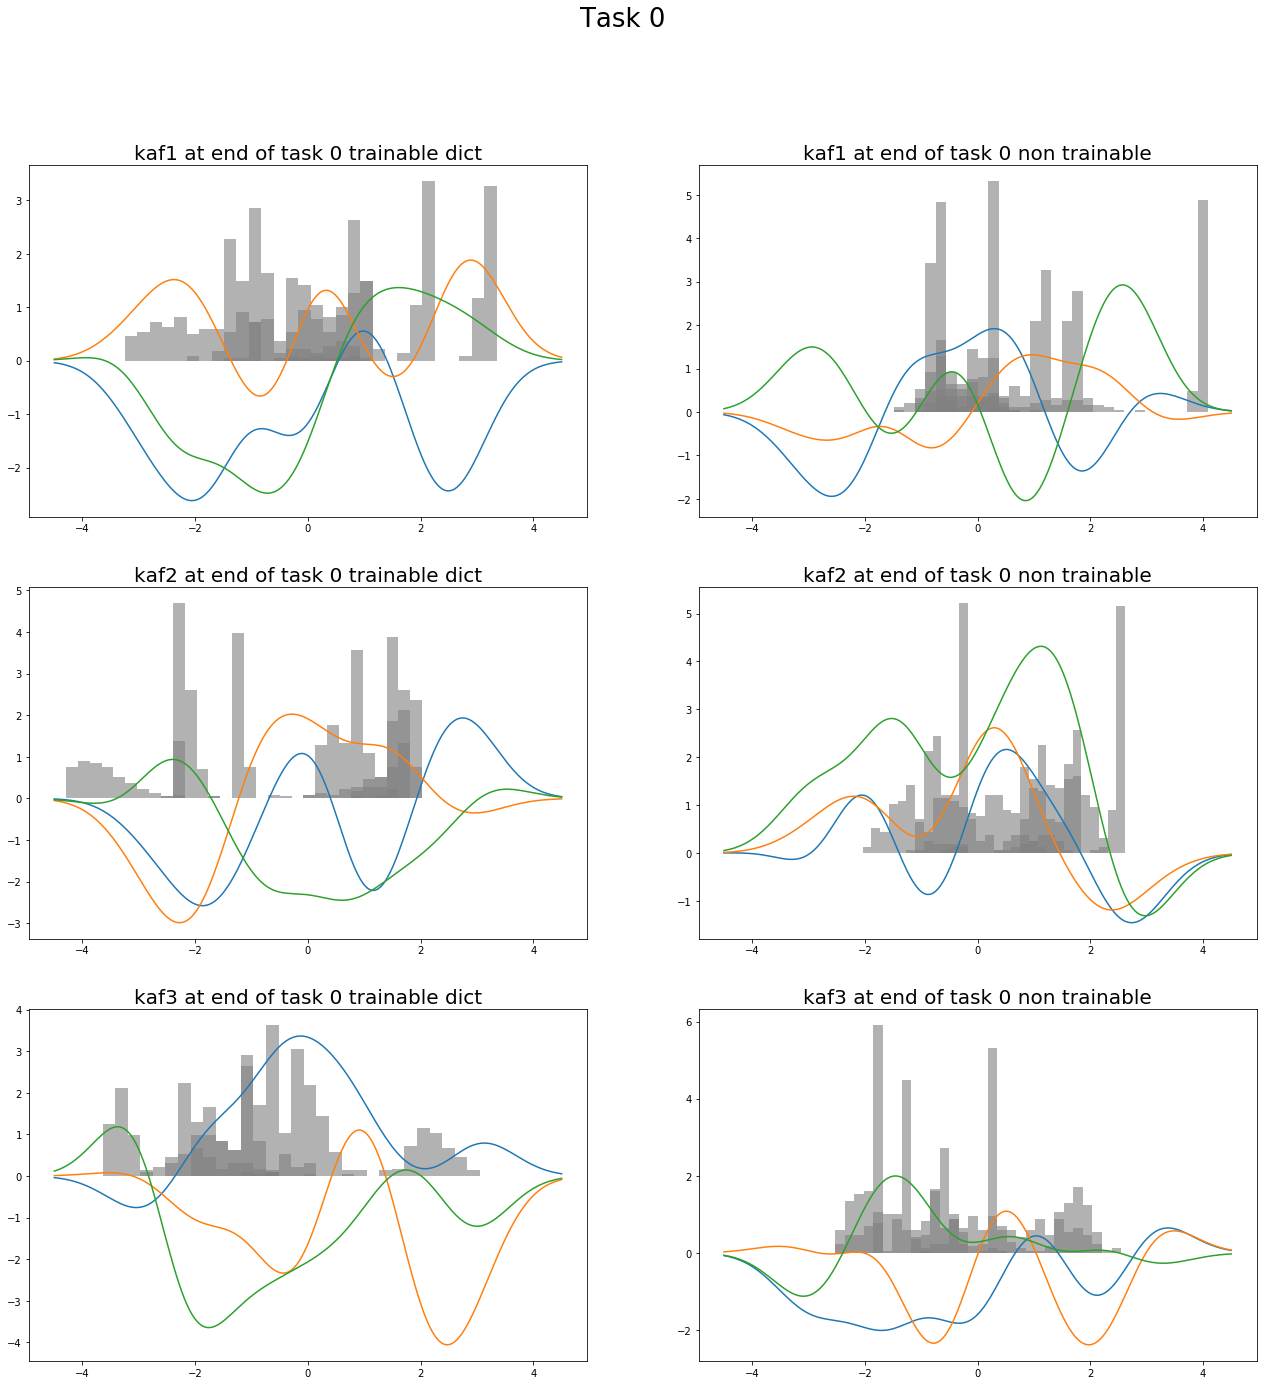

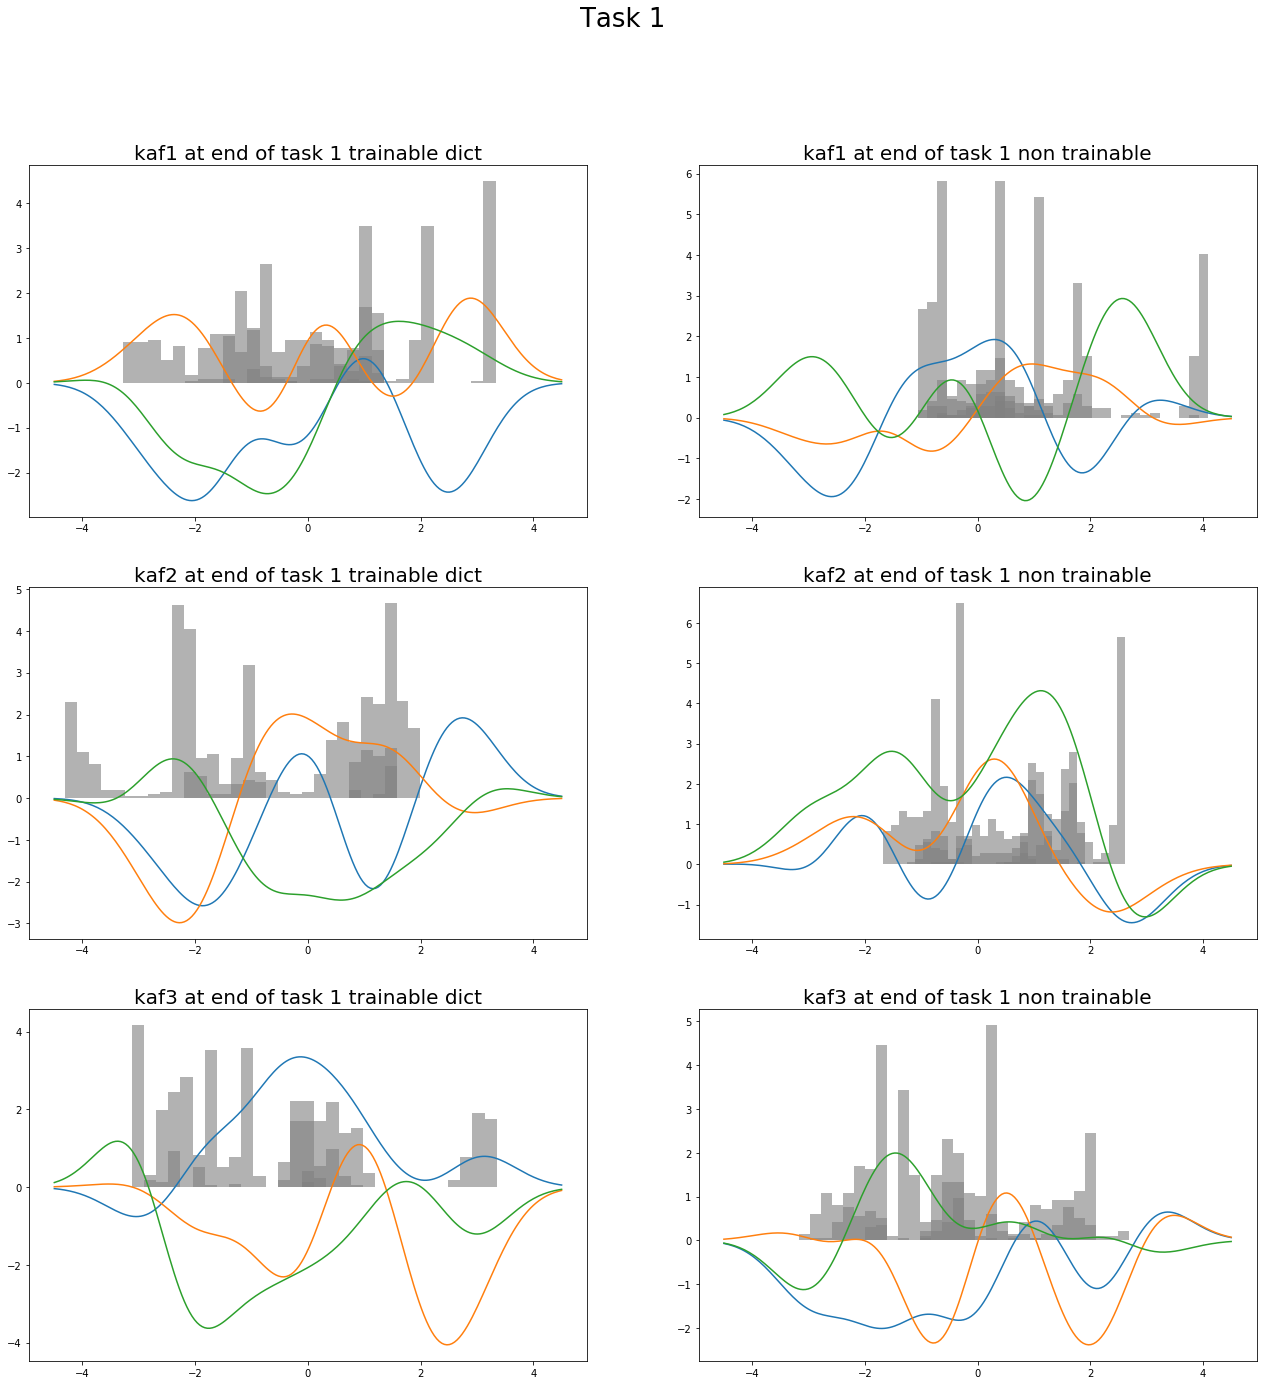

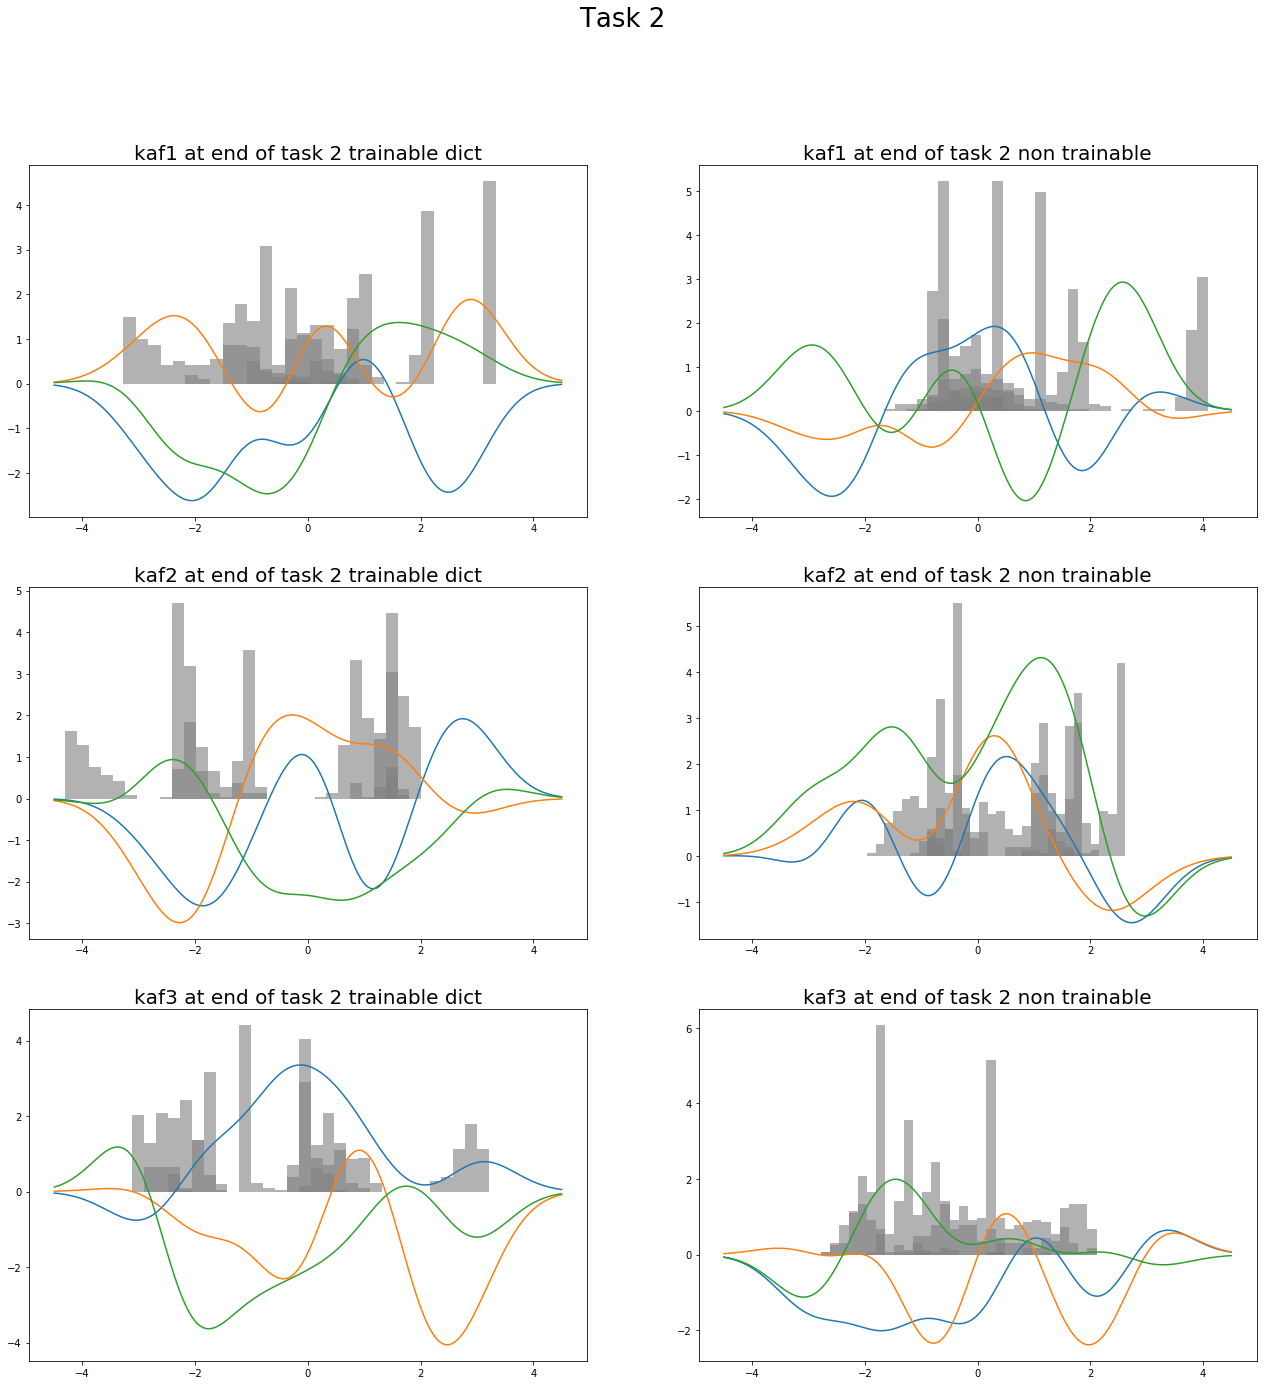

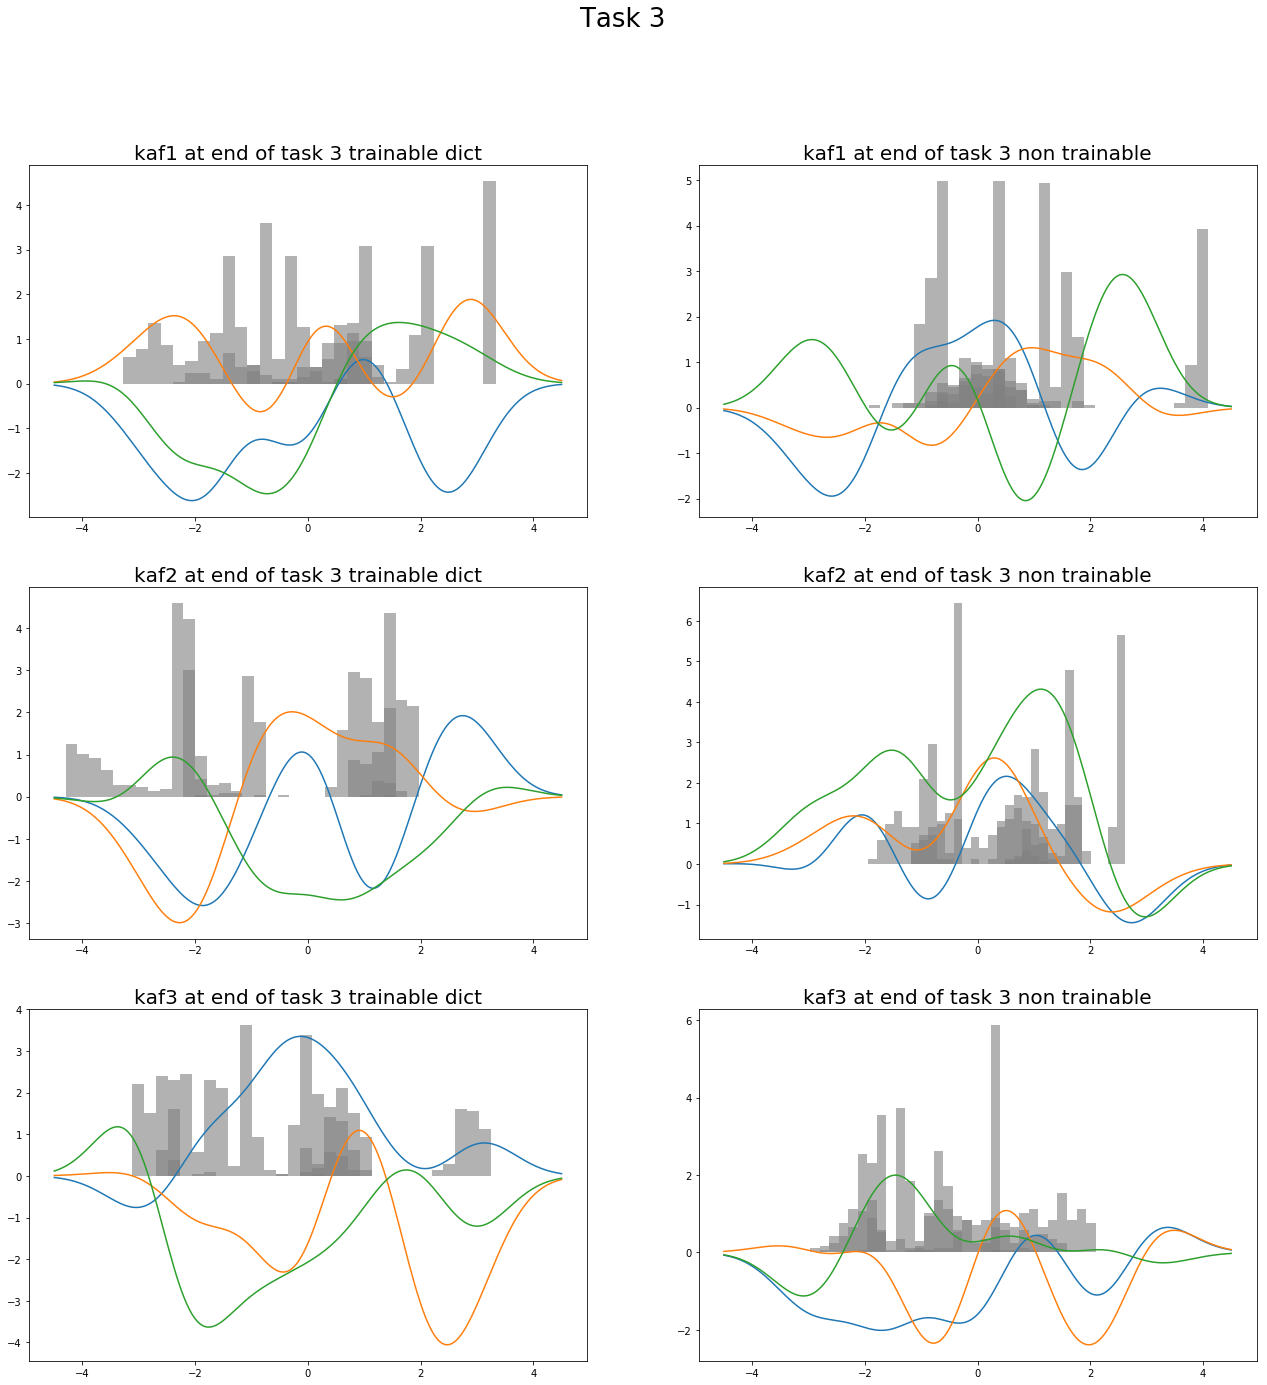

In [14]:
neurons = np.random.randint(low=1, high=int(400*0.7), size=10) 
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)

x = list(range(20))
common_params = {'histtype': 'step'}

# fig = plt.figure(figsize=(22, 22))
# ax = fig.add_subplot(111, projection='3d')

x_labels = []
space = np.linspace(-4.5, 4.5, 100)
kaf_net = nontrainable_net 

for i in np.arange(4):
    fig = plt.figure(figsize=(22, 22))
    fig.suptitle('Task {}'.format(i), fontsize=26)
    
    idx = iter([1, 3, 5, 2, 4, 6])

    n = deepcopy(trainable_net)
    config = deepcopy(configOnline)

    config.MODEL_NAME = name

    trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

    r = trainer.load(i)
    model = trainer.model.cpu()
        
    for _, m in model.named_modules():
        m.register_forward_hook(hook)
    
    dataset.task = i
    it = dataset.getIterator(1)
    
    imgs = []
    for _ in range(100):
        imgs.append(torch.Tensor(next(it)[0]))
    
    
    for l in [1, 2, 3]:
        name = 'kaf'+str(l)

        kaf = getattr(model, name)
        c = []

        for img in imgs:
            model(img)
            hooked_val = getattr(kaf, '_value_hook')[0].detach().cpu().numpy()
            c.append([hooked_val[n] for n in neurons])
        
        ax = fig.add_subplot(3, 2, next(idx))
        ax.hist(x=np.asarray(c), histtype='stepfilled', density=True, alpha=0.6, color = ["grey"]*10, bins=30)
        ax.set_title('{} at end of task {} trainable dict'.format(name, i), fontdict={'fontsize':20})
                  
        act_fun = []
        
        for j in space.astype(np.float32):
            input = torch.Tensor([j]).unsqueeze(0)
            res = kaf.forward(input).detach().cpu().numpy()[0]
            act_fun.append([res[n] for n in neurons[:3]])
    
        act_fun = np.asarray(act_fun)
        for j in range(act_fun.shape[1]):
            vals = act_fun[:, j]
            spl = make_interp_spline(space, vals, k=3)
            xnew = np.linspace(min(space), max(space), 200)
            ax.plot(xnew, spl(xnew))
        
#         plt.show()
    
    n = deepcopy(nontrainable_net)
    config = deepcopy(configOnline)

    config.MODEL_NAME = name

    trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

    r = trainer.load(i)
    model = trainer.model.cpu()
        
    for _, m in model.named_modules():
        m.register_forward_hook(hook)
    
    dataset.task = i
    it = dataset.getIterator(1)
    
    imgs = []
    for _ in range(100):
        imgs.append(torch.Tensor(next(it)[0]))
        
    for l in [1, 2, 3]:
        name = 'kaf'+str(l)

        kaf = getattr(model, name)
        c = []

        for img in imgs:
            model(img)
            hooked_val = getattr(kaf, '_value_hook')[0].detach().cpu().numpy()
            c.append([hooked_val[n] for n in neurons])
            
#         fig = plt.figure(figsize=(22, 22))
        ax = fig.add_subplot(3, 2, next(idx))
        ax.hist(x=np.asarray(c), histtype='stepfilled', density=True, alpha=0.6, color = ["grey"]*10, bins=30)
        ax.set_title('{} at end of task {} non trainable'.format(name, i), fontdict={'fontsize':20})
                  
        act_fun = []
        
        for j in space.astype(np.float32):
            input = torch.Tensor([j]).unsqueeze(0)
            res = kaf.forward(input).detach().cpu().numpy()[0]
            act_fun.append([res[n] for n in neurons[:3]])
    
        act_fun = np.asarray(act_fun)
        for j in range(act_fun.shape[1]):
            vals = act_fun[:, j]
            spl = make_interp_spline(space, vals, k=3)
            xnew = np.linspace(min(space), max(space), 200)
            ax.plot(xnew, spl(xnew))
        
    plt.show()

